# 한국학 저널(OpenAlex) 토크나이징

In [102]:
import pandas as pd
import numpy as np
import spacy
spacy.prefer_gpu(1)
nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
from tqdm.auto import tqdm
tqdm.pandas()
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import simple_preprocess
from collections import Counter
import re
from ast import literal_eval

In [103]:
df = pd.read_pickle('./240407_KS_KCI_merged.pkl')
df

,id,doi,journal,origin,title,publication_year,abstract,oa_kci,cited_by_count
0,https://openalex.org/W4384432764,https://doi.org/10.1353/seo.2023.a902140,Seoul Journal of Korean Studies,in,Felled Forests and Fallowed Fields: Establishi...,2023,Goryeo (918–1392) was a politically and commer...,oa,1
1,https://openalex.org/W4384432829,https://doi.org/10.1353/seo.2023.a902142,Seoul Journal of Korean Studies,in,The History of the Formation of Silhak in Mode...,2023,This article examines the historical trajector...,oa,1
2,https://openalex.org/W1578642520,https://doi.org/10.1353/seo.2015.0003,Seoul Journal of Korean Studies,in,Diplomatic War: Inter-Korean Relations in the ...,2015,The period of the 1970s was a turning point in...,oa,5
3,https://openalex.org/W1590043962,https://doi.org/10.1353/seo.2013.0023,Seoul Journal of Korean Studies,in,More Valuable than Gold: Korean Tungsten and t...,2013,A central component of the Japanese government...,oa,5
4,https://openalex.org/W210363985,https://doi.org/10.1353/seo.2014.0005,Seoul Journal of Korean Studies,in,Parhae in Historiography and Archaeology: Inte...,2014,The history of the kingdom of Parhae (Ch. Boha...,oa,5
...,...,...,...,...,...,...,...,...,...
2892,ART002721077,https://doi.org/10.25024/review.2021.24.1.009,The Review of Korean Studies,in,The Haunted Maiden Deities on Jeju Island,2021,Jeju Island reveals exemplary openness to ghos...,kci,<NA>
2893,ART002721082,https://doi.org/10.25024/review.2021.24.1.010,The Review of Korean Studies,in,A Study on Trauma Aspects in Cho Se-Hee’s Nove...,2021,The aim of this paper is to study the problems...,kci,<NA>
2894,ART002721086,https://doi.org/10.25024/review.2021.24.1.012,The Review of Korean Studies,in,A Chinese Scholar’s View on the Costume of Gog...,2021,NaN,kci,<NA>
2895,ART002721085,https://doi.org/10.25024/review.2021.24.1.011,The Review of Korean Studies,in,Current Status of Korean Studies in China,2021,NaN,kci,<NA>


In [106]:
df['cited_by_count'].fillna(0).describe()

/tmp/ipykernel_1708977/1448256736.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cited_by_count'].fillna(0).describe()


count    2897.000000
mean        1.572661
std         5.372484
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        93.000000
Name: cited_by_count, dtype: float64

In [107]:
journal_empty_abstract_percent = df.groupby('journal')['abstract'].apply(lambda x: x.isnull().mean() * 100)
journal_empty_abstract_percent

journal
Acta Koreana                           8.904110
European Journal of Korean Studies     0.980392
Korea Journal                         19.494585
Korean Studies                        50.934579
Seoul Journal of Korean Studies       29.943503
The Journal of Korean Studies         39.439655
The Review of Korean Studies          38.691323
Name: abstract, dtype: float64

In [108]:
stop_words = stopwords.words('english')
stop_words.extend(['-','abstract','review','book'])

In [109]:
def lemmatization(texts, allowed_postags): #https://spacy.io/api/annotation#
        texts_out = []
        print('lemmatization 시작 \n')
        for sent in tqdm(texts):
                if sent!=None:
                        doc = nlp(sent)
                        if allowed_postags != None:
                                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
                        else:
                                texts_out.append([token.lemma_ for token in doc])
                else:
                        texts_out.append(None)
        return texts_out

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        # return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigram(data_words,bigram_min_count):
        bigram = gensim.models.Phrases(data_words, min_count=bigram_min_count)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        # bigram으로 만들기
        data_words_bigrams = [bigram_mod[doc] for doc in remove_stopwords(data_words)] # 불용어 1차 제거 후에 bigram
        # data_lemmatized = remove_stopwords(lemmatization(data_words_bigrams,allowed_postags=['NOUN','PROPN','ADJ','ADV','VERB'])) #lemm 이후 불용어 추가 제거
        return data_words_bigrams

In [110]:
title_lemmatized = lemmatization(df['title'].str.lower().tolist(),['NOUN','PROPN','ADJ','VERB']) # 명사, 대명사, 형용사 활용

lemmatization 시작 



  0%|          | 0/2897 [00:00<?, ?it/s]

In [111]:
df['title_tokens'] = pd.Series(title_lemmatized)

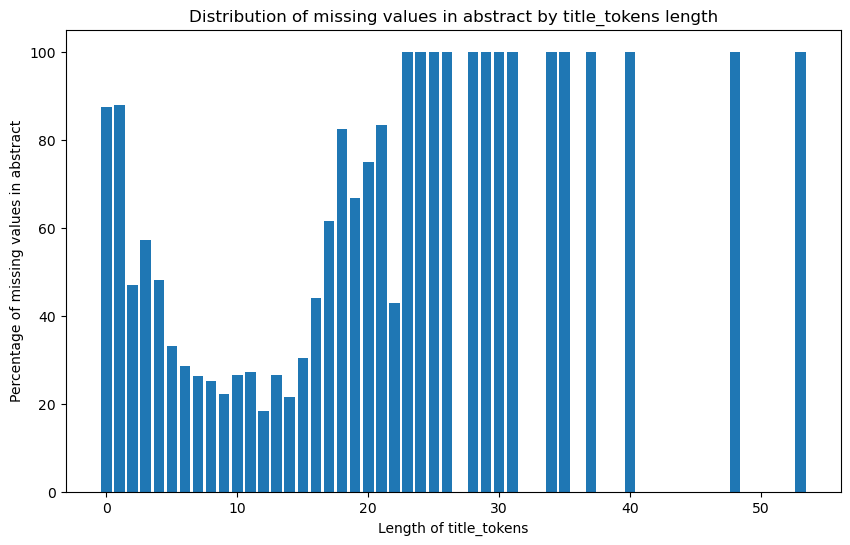

title_tokens
0      87.500000
1      87.804878
2      46.969697
3      57.142857
4      48.148148
5      33.165829
6      28.571429
7      26.344086
8      25.063291
9      22.121212
10     26.394052
11     27.272727
12     18.292683
13     26.506024
14     21.538462
15     30.357143
16     43.902439
17     61.538462
18     82.352941
19     66.666667
20     75.000000
21     83.333333
22     42.857143
23    100.000000
24    100.000000
25    100.000000
26    100.000000
27      0.000000
28    100.000000
29    100.000000
30    100.000000
31    100.000000
34    100.000000
35    100.000000
37    100.000000
40    100.000000
48    100.000000
53    100.000000
Name: abstract, dtype: float64

In [112]:
import matplotlib.pyplot as plt

# Calculate the percentage of missing values in abstract column for each title_tokens length
missing_values_percent = df.groupby(df['title_tokens'].str.len())['abstract'].apply(lambda x: x.isnull().mean() * 100)

# Plot the distribution of missing values
plt.figure(figsize=(10, 6))
plt.bar(missing_values_percent.index, missing_values_percent.values)
plt.xlabel('Length of title_tokens')
plt.ylabel('Percentage of missing values in abstract')
plt.title('Distribution of missing values in abstract by title_tokens length')
plt.show()
df.groupby(df['title_tokens'].str.len())['abstract'].apply(lambda x: x.isnull().mean() * 100)


In [113]:
# df = df[(df['title_tokens'].str.len()>=3)&(df['title_tokens'].str.len()<=25)].reset_index(drop=True) # 토큰수 3~25개 사이만 남김
df.loc[(df['title_tokens'].str.len()<3)|(df['title_tokens'].str.len()>25),'abstract'] = pd.NA

In [114]:
df['journal'].value_counts()

journal
The Review of Korean Studies          703
Korea Journal                         554
The Journal of Korean Studies         464
Korean Studies                        428
Seoul Journal of Korean Studies       354
Acta Koreana                          292
European Journal of Korean Studies    102
Name: count, dtype: int64

In [115]:
df['origin'].value_counts()

origin
in     1903
out     994
Name: count, dtype: int64

In [116]:
abstract_lemmatized = lemmatization(df['abstract'].apply(lambda x: x.lower() if isinstance(x, str) else None).tolist(),['NOUN','PROPN','ADJ','VERB']) # 명사, 대명사, 형용사 활용

lemmatization 시작 



  0%|          | 0/2897 [00:00<?, ?it/s]

In [129]:
df['abstract_tokens'] = pd.Series(abstract_lemmatized)  # abstract_tokens column 추가

In [118]:
df['abstract_tokens'].str.len().describe()

count    1941.000000
mean      126.931479
std       118.132609
min         2.000000
25%        88.000000
50%       108.000000
75%       130.000000
max      1546.000000
Name: abstract_tokens, dtype: float64

<Axes: >

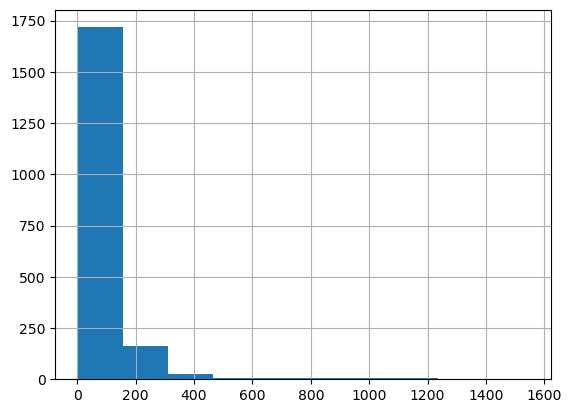

In [119]:
df['abstract_tokens'].str.len().hist()

In [130]:
# 초록 토큰수가 20개 미만이거나 300개 이상인 경우 NA로 대체
df.loc[(df['abstract_tokens'].str.len()<20)|(df['abstract_tokens'].str.len()>=300),'abstract_tokens'] = pd.NA

In [101]:
df['oa_kci'].value_counts()

oa_kci
oa     2731
kci     166
Name: count, dtype: int64

In [132]:
# 토큰 없는 경우 na가 아니라 []로 처리
df['title_tokens'] = df['title_tokens'].apply(lambda x: x if isinstance(x, list) else [])
df['abstract_tokens'] = df['abstract_tokens'].apply(lambda x: x if isinstance(x, list) else [])
df['tokens'] = df.apply(lambda row: row['title_tokens'] + row['abstract_tokens'], axis=1)

In [133]:
bigrams = make_bigram(df['tokens'].tolist(),10)
# bigram 단어 확인
bigram_list = [word for sent in bigrams for word in sent if "_" in word]
Counter(bigram_list).most_common(100) # 상위 N개

[('south_korea', 724),
 ('north_korea', 376),
 ('north_korean', 365),
 ('south_korean', 362),
 ('article_examine', 207),
 ('cold_war', 203),
 ('korean_peninsula', 170),
 ('korean_society', 156),
 ('japanese_colonial', 149),
 ('east_asian', 146),
 ('east_asia', 140),
 ('united_states', 140),
 ('paper_examine', 122),
 ('colonial_period', 115),
 ('nineteenth_century', 92),
 ('joseon_dynasty', 90),
 ('zhu_xi', 90),
 ('republic_korea', 81),
 ('study_examine', 76),
 ('twentieth_century', 73),
 ('article_explore', 71),
 ('late_chosŏn', 71),
 ('kim_il', 71),
 ('eighteenth_century', 66),
 ('late_joseon', 62),
 ('take_place', 61),
 ('soviet_union', 60),
 ('article_argue', 59),
 ('national_identity', 58),
 ('park_chung', 56),
 ('case_study', 54),
 ('samguk_sagi', 54),
 ('nation_state', 53),
 ('king_sejong', 53),
 ('chosŏn_dynasty', 53),
 ('paper_argue', 49),
 ('early_twentieth', 48),
 ('confucian_scholar', 48),
 ('paper_analyze', 47),
 ('sixteenth_century', 47),
 ('popular_culture', 47),
 ('every

In [134]:
# Trigram 생성 함수 정의
def make_trigram(data_words, bigram_min_count, trigram_min_count):
    # Bigram 모델 생성
    bigram = gensim.models.Phrases(data_words, min_count=bigram_min_count)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    # Bigram 적용
    data_words_bigrams = [bigram_mod[doc] for doc in remove_stopwords(data_words)]
    
    # Trigram 모델 생성
    trigram = gensim.models.Phrases(data_words_bigrams, min_count=trigram_min_count)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Trigram 적용
    data_words_trigrams = [trigram_mod[doc] for doc in data_words_bigrams]
    
    return data_words_trigrams

In [135]:
# Trigram 생성 (bigram_min_count와 trigram_min_count는 예시 데이터에 따라 조정)
trigrams = make_trigram(df['tokens'].tolist(), bigram_min_count=10, trigram_min_count=30)
# trigram 단어 확인 (bigram 제외)
trigram_only_list = [word for sent in trigrams for word in sent if word.count("_") == 2]
Counter(trigram_only_list).most_common(100)  # 상위 N개

[('kim_il_sung', 58), ('early_twentieth_century', 48), ('park_chung_hee', 37)]

In [136]:
len(trigrams)

2897

In [137]:
df['tokens'] = pd.Series(trigrams)
df['tokens']

0       [fell, forest, fallowe, field, establish, narr...
1       [history, formation, silhak, modern, korea, pr...
2       [diplomatic, war, inter, korean, relation, per...
3       [valuable, gold, korean, tungsten, japanese, w...
4       [parhae, historiography, archaeology, internat...
                              ...                        
2892    [haunted, maiden, deity, jeju, island, jeju, i...
2893    [study, trauma, aspect, cho, se, hee, novels, ...
2894    [chinese, scholar, view, costume, goguryeo, ac...
2895              [current, status, korean, study, china]
2896    [marginal, man, notebook, history, contemporar...
Name: tokens, Length: 2897, dtype: object

In [24]:
# 불용어 제거
df['tokens'] = df['tokens'].progress_map(lambda x:[w for w in x if w not in set(stop_words)])

  0%|          | 0/2761 [00:00<?, ?it/s]

In [138]:
df

,id,doi,journal,origin,title,publication_year,abstract,oa_kci,cited_by_count,title_tokens,abstract_tokens,tokens
0,https://openalex.org/W4384432764,https://doi.org/10.1353/seo.2023.a902140,Seoul Journal of Korean Studies,in,Felled Forests and Fallowed Fields: Establishi...,2023,Goryeo (918–1392) was a politically and commer...,oa,1,"[fell, forest, fallowe, field, establish, narr...","[goryeo, integrate, part, wide, mongol, empire...","[fell, forest, fallowe, field, establish, narr..."
1,https://openalex.org/W4384432829,https://doi.org/10.1353/seo.2023.a902142,Seoul Journal of Korean Studies,in,The History of the Formation of Silhak in Mode...,2023,This article examines the historical trajector...,oa,1,"[history, formation, silhak, modern, korea, pr...","[article, examine, historical, trajectory, con...","[history, formation, silhak, modern, korea, pr..."
2,https://openalex.org/W1578642520,https://doi.org/10.1353/seo.2015.0003,Seoul Journal of Korean Studies,in,Diplomatic War: Inter-Korean Relations in the ...,2015,The period of the 1970s was a turning point in...,oa,5,"[diplomatic, war, inter, -, korean, relation, ...","[period, 1970, turning, point, relation, north...","[diplomatic, war, inter, korean, relation, per..."
3,https://openalex.org/W1590043962,https://doi.org/10.1353/seo.2013.0023,Seoul Journal of Korean Studies,in,More Valuable than Gold: Korean Tungsten and t...,2013,A central component of the Japanese government...,oa,5,"[valuable, gold, korean, tungsten, japanese, w...","[central, component, japanese, government, for...","[valuable, gold, korean, tungsten, japanese, w..."
4,https://openalex.org/W210363985,https://doi.org/10.1353/seo.2014.0005,Seoul Journal of Korean Studies,in,Parhae in Historiography and Archaeology: Inte...,2014,The history of the kingdom of Parhae (Ch. Boha...,oa,5,"[parhae, historiography, archaeology, internat...","[history, kingdom, parhae, ch, ., bohai, jp, ....","[parhae, historiography, archaeology, internat..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2892,ART002721077,https://doi.org/10.25024/review.2021.24.1.009,The Review of Korean Studies,in,The Haunted Maiden Deities on Jeju Island,2021,Jeju Island reveals exemplary openness to ghos...,kci,<NA>,"[haunted, maiden, deity, jeju, island]","[jeju, island, reveal, exemplary, openness, gh...","[haunted, maiden, deity, jeju, island, jeju, i..."
2893,ART002721082,https://doi.org/10.25024/review.2021.24.1.010,The Review of Korean Studies,in,A Study on Trauma Aspects in Cho Se-Hee’s Nove...,2021,The aim of this paper is to study the problems...,kci,<NA>,"[study, trauma, aspect, cho, se, -, hee, novel...","[aim, paper, study, problem, cause, trauma, as...","[study, trauma, aspect, cho, se, hee, novels, ..."
2894,ART002721086,https://doi.org/10.25024/review.2021.24.1.012,The Review of Korean Studies,in,A Chinese Scholar’s View on the Costume of Gog...,2021,NaN,kci,<NA>,"[chinese, scholar, view, costume, goguryeo, ac...",[],"[chinese, scholar, view, costume, goguryeo, ac..."
2895,ART002721085,https://doi.org/10.25024/review.2021.24.1.011,The Review of Korean Studies,in,Current Status of Korean Studies in China,2021,NaN,kci,<NA>,"[current, status, korean, study, china]",[],"[current, status, korean, study, china]"


In [139]:
df.to_pickle('./240407_KS_KCI_merged_tokens.pkl')